Generate all the guest graphs and pickle them

In [5]:
from ember.sample import *
import pickle

edge_densities = ["low", "medium", "high"]

guest_generators = {
    "barabasi_albert": barabasi_albert_graph,
    "d_regular": d_regular_graph,
    "erdos_reyni": erdos_reyni_graph,
    "noisy_bipartite": noisy_bipartite_graph
}
seeds = [10, 20, 30, 40, 50]

all_guests = {}

for graph_type, generator in guest_generators.items():
    print(f"Generating graph type: {graph_type}")
    all_guests[graph_type] = {}
    for edge_density in edge_densities:
        all_guests[graph_type][edge_density] = {}
        for num_nodes in range(10, 65):
            all_guests[graph_type][edge_density][num_nodes] = {}
            for i, seed in enumerate(seeds):
                all_guests[graph_type][edge_density][num_nodes][i] = generator(
                    num_nodes, edge_density, seed)

    with open(f'small_guests/{graph_type}.pickle', 'wb') as handle:
        pickle.dump(all_guests[graph_type], handle, protocol=pickle.HIGHEST_PROTOCOL)


Generating graph type: barabasi_albert
Generating graph type: d_regular
Generating graph type: erdos_reyni
Generating graph type: noisy_bipartite


Load the guest graphs from the pickles

In [13]:
import pickle

guest_types = {
    "barabasi_albert",
    "d_regular",
    "erdos_reyni",
    "noisy_bipartite"
}

all_guests = {}

for graph_type in guest_types:
     with open(f'guests/{graph_type}.pickle', 'rb') as handle:
            all_guests[graph_type] = pickle.load(handle)


Draw some graphs to check

1200

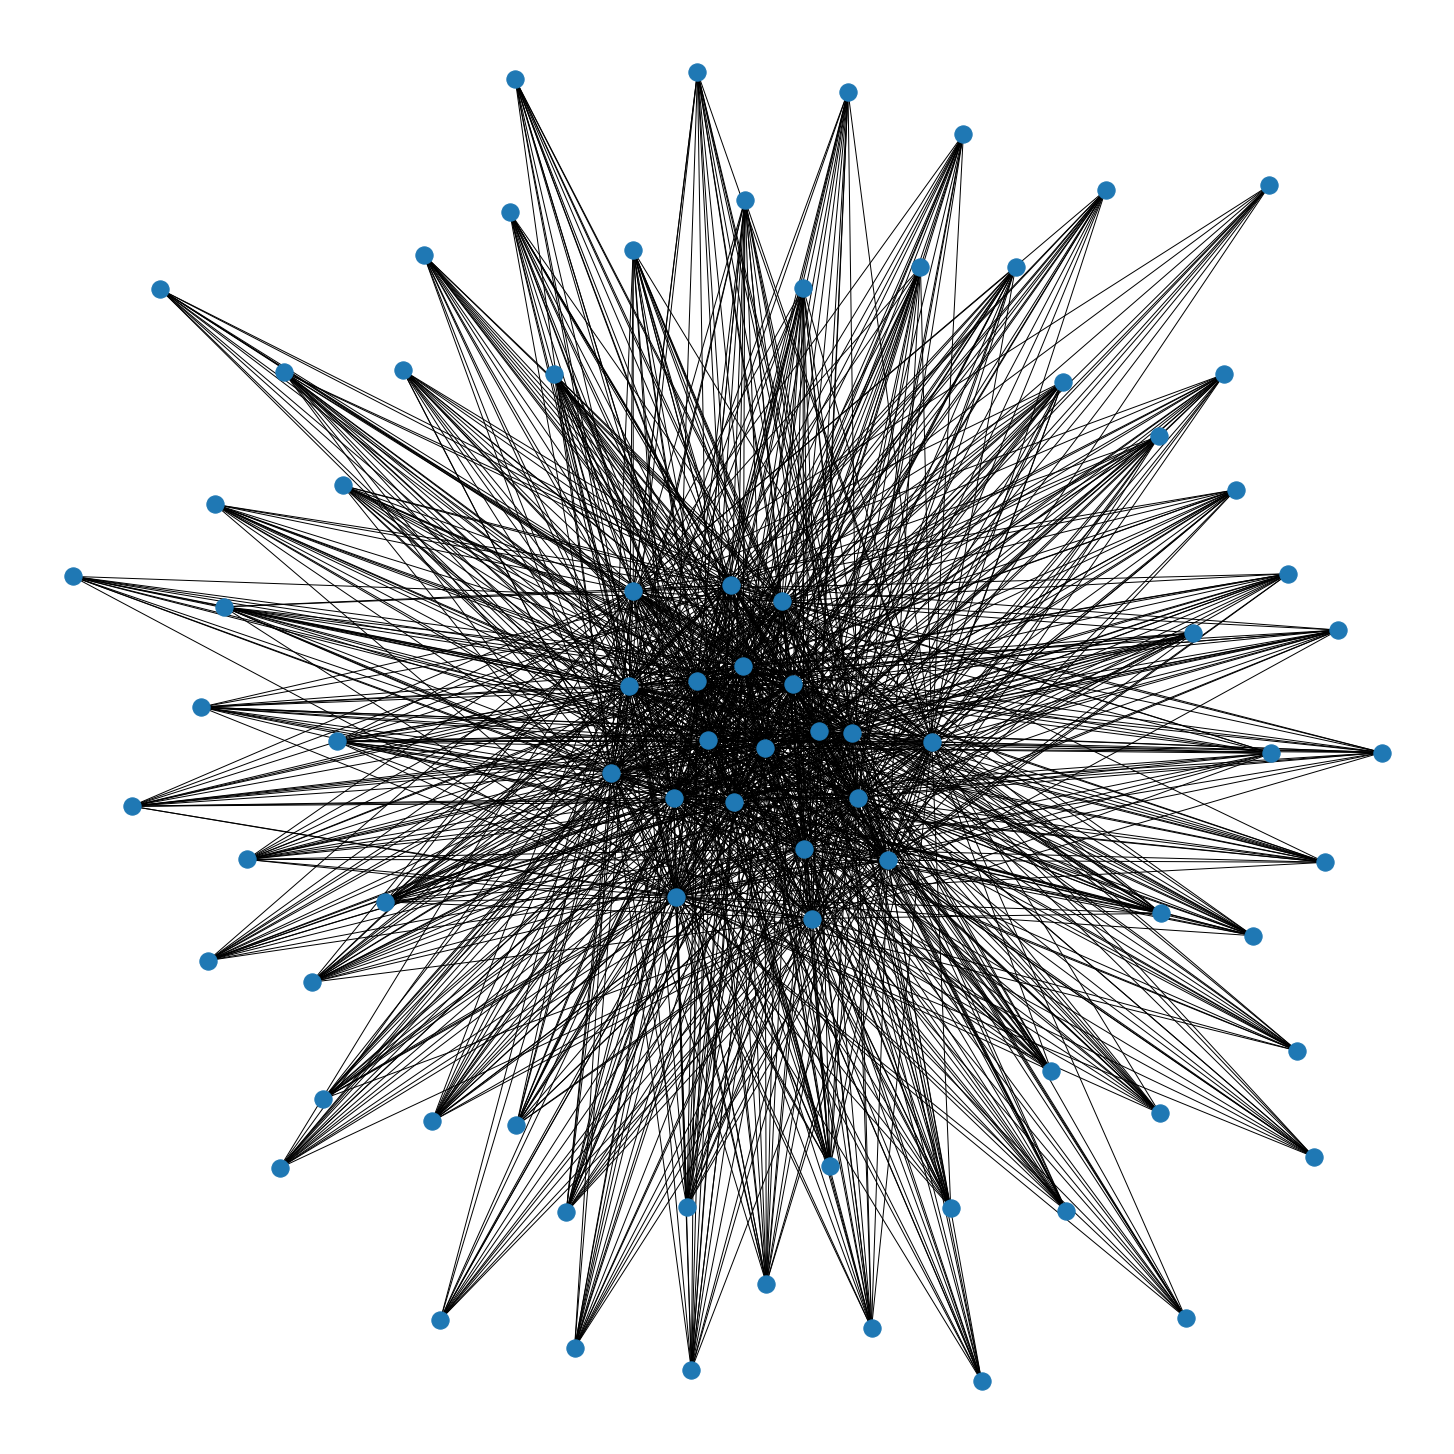

In [12]:
from matplotlib import pyplot as plt
import networkx as nx

plt.ion()
plt.figure(figsize=(20, 20))
g =all_guests["barabasi_albert"]["high"][80][2]
nx.draw(g)
# nx.draw(all_guests["erdos_reyni"][70]["medium"][2])

len(g.edges)

Start of benchmarking

In [2]:
non_faulty_results = {}
faulty_results = {}

def get_chain_stats(emb):
    length = [len(chain) for chain in emb.values()]
    length = sorted(length)
    max_length = length[-1]
    mid = len(length) // 2
    median_length = (length[mid] + length[~mid]) / 2
    qubits_used = sum(length)
    return max_length, median_length, qubits_used



Non-faulty test harness

In [ ]:
from ember.util import *
from ember.hardware.chimera import D_WAVE_2000Q
import time

host = D_WAVE_2000Q()

def run_benchmark(embed_func):
    results = {}
    for graph_type in ["barabasi_albert", "d_regular", "erdos_reyni", "noisy_bipartite"]:
        print(f"graph type: {graph_type}")
        results[graph_type] = {}
        for density in ["low","medium", "high"]:
            print(f"density : {density}")
            results[graph_type][density] = {}
            for size in range(65, 96):
                print(f"size:  {size}")
                found = False
                for instance in range(5):
                    guest = all_guests[graph_type][density][size][instance]
                    start_time = time.time()
                    emb = embed_func(guest, host)
                    total = time.time() - start_time
                    if check_embedding(emb, guest, host):
                        found = True
                        max_chain, median_length, qubits_used = get_chain_stats(emb)
                        data = {
                            "max_chain_length": max_chain,
                            "median_chain_length": median_length,
                            "qubits_used": qubits_used,
                            "walltime": total}
                        print(data)
                        results[graph_type][density][size] = data
                        break
                if not found:
                    break
    return results

Minorminer

In [ ]:
from minorminer import find_embedding

def minor_miner_embed_func(guest, host):
    return find_embedding(guest, host, tries=1)

non_faulty_results["minorminer"] = run_benchmark(minor_miner_embed_func)

with open('results/non_faulty_minorminer.pickle', 'wb') as handle:
    pickle.dump(non_faulty_results["minorminer"], handle, protocol=pickle.HIGHEST_PROTOCOL)

PSSA

In [17]:
from ember.pssa.optimize import run_simulated_annealing
from ember.pssa.model import ProbabilisticSwapShiftModel
from ember.hardware.chimera import D_WAVE_2000Q
import random

T_MAX = 10**6

def pssa_schedule(iter_count):
    progress_ratio = iter_count / T_MAX
    if 0 <= iter_count < (T_MAX // 2):
        temperature = 0.603 * (1 - 2 * progress_ratio)
    else:
        temperature = 0.334 * 2 * (1 - progress_ratio)
    shift = random.random() < min(1.2 * progress_ratio, 0.7)
    if shift:
        if progress_ratio < 0.5:
            any_dir = random.random() < progress_ratio * 0.8
        else:
            any_dir = True
    else:
        any_dir = False
    return temperature, shift, any_dir

def pssa_func(guest, host):
    model = ProbabilisticSwapShiftModel(guest, host)
    return run_simulated_annealing(model, pssa_schedule, T_MAX)

host = D_WAVE_2000Q()

non_faulty_results["pssa"] = run_benchmark3("nonfaulty", "pssa", host, pssa_func)

with open('results/non_faulty_pssa.pickle', 'wb') as handle:
    pickle.dump(non_faulty_results["pssa"], handle, protocol=pickle.HIGHEST_PROTOCOL)

# BA
# LOW
# 66
# max_chain_length': 17, 'median_chain_length': 17.0, 'qubits_used': 1088, 'walltime': 61.69841980934143
# MED
# 66
# {'max_chain_length': 17, 'median_chain_length': 17.0, 'qubits_used': 1088, 'walltime': 2.3385000228881836}

graph type: erdos_reyni
density : low
size:  65
Optimal: 493
Updated best cost: 478
Updated best cost: 479
Updated best cost: 480
Updated best cost: 481
Updated best cost: 482
Updated best cost: 483
Updated best cost: 484
Updated best cost: 485
Updated best cost: 486
Updated best cost: 487
Updated best cost: 488
Updated best cost: 489
Updated best cost: 490
Updated best cost: 491
Updated best cost: 492
Updated best cost: 493
Solution found
Embedding found
{'max_chain_length': 17, 'median_chain_length': 17.0, 'qubits_used': 1088, 'walltime': 1.9433538913726807}
size:  66
Optimal: 506
Updated best cost: 472
Updated best cost: 476
Updated best cost: 477
Updated best cost: 478
Updated best cost: 480
Updated best cost: 481
Updated best cost: 482
Updated best cost: 483
Updated best cost: 484
Updated best cost: 485
Updated best cost: 486
Updated best cost: 487
Updated best cost: 488
Updated best cost: 489
Updated best cost: 490
Updated best cost: 491
Updated best cost: 493
Updated best cost: 

COA

In [4]:
from ember.pssa.optimize import run_simulated_annealing
from ember.pssa.model import CliqueOverlapModel
import random

T_MAX = 10**6

def coa_schedule(iter_count):
    progress_ratio = iter_count / T_MAX
    if 0 <= iter_count < (T_MAX // 2):
        temperature = 0.603 * (1 - 2 * progress_ratio)
    else:
        temperature = 0.334 * 2 * (1 - progress_ratio)
    shift = random.random() > ((0.3 * progress_ratio - 1) ** 2)
    return temperature, shift, None

def coa_func(guest, host):
    model = CliqueOverlapModel(guest, host)
    return run_simulated_annealing(model, coa_schedule, T_MAX)

non_faulty_results["coa"] = run_benchmark(coa_func)

with open('results/non_faulty_coa.pickle', 'wb') as handle:
    pickle.dump(non_faulty_results["coa"], handle, protocol=pickle.HIGHEST_PROTOCOL)



graph type: noisy_bipartite
density : medium
size:  65
Optimal: 677
Updated best cost: 676
Updated best cost: 677
Solution found
Embedding found
{'max_chain_length': 32, 'median_chain_length': 24.0, 'qubits_used': 1583, 'walltime': 2.81520676612854}
size:  66
Optimal: 716
No solution found
Embedding not found
Optimal: 716
Updated best cost: 714
Updated best cost: 715
Updated best cost: 716
Solution found
Embedding found
{'max_chain_length': 32, 'median_chain_length': 24.0, 'qubits_used': 1598, 'walltime': 2.395181894302368}
size:  67
Optimal: 714
Updated best cost: 711
Updated best cost: 712
Updated best cost: 713
Updated best cost: 714
Solution found
Embedding found
{'max_chain_length': 32, 'median_chain_length': 24.0, 'qubits_used': 1613, 'walltime': 2.438416004180908}
size:  68
Optimal: 733
Updated best cost: 732
Updated best cost: 733
Solution found
Embedding found
{'max_chain_length': 32, 'median_chain_length': 24.0, 'qubits_used': 1628, 'walltime': 2.472214937210083}
size:  69
Op

In [3]:
with open('checkpoint/nonfaulty_pssa_6.pickle', 'rb') as handle:
    temp = pickle.load(handle)

temp

{'barabasi_albert': {'low': {65: {'max_chain_length': 17,
    'median_chain_length': 17.0,
    'qubits_used': 1088,
    'walltime': 28.10988473892212},
   66: {'max_chain_length': 34,
    'median_chain_length': 17.0,
    'qubits_used': 1088,
    'walltime': 116.7741630077362}},
  'medium': {65: {'max_chain_length': 23,
    'median_chain_length': 17.0,
    'qubits_used': 1088,
    'walltime': 85.43173909187317}},
  'high': {}},
 'd_regular': {'low': {65: {'max_chain_length': 17,
    'median_chain_length': 17.0,
    'qubits_used': 1088,
    'walltime': 1.2212929725646973},
   66: {'max_chain_length': 21,
    'median_chain_length': 17.0,
    'qubits_used': 1088,
    'walltime': 54.60391402244568},
   67: {'max_chain_length': 20,
    'median_chain_length': 17.0,
    'qubits_used': 1088,
    'walltime': 66.18550395965576}},
  'medium': {65: {'max_chain_length': 17,
    'median_chain_length': 17.0,
    'qubits_used': 1088,
    'walltime': 119.99079012870789}},
  'high': {}},
 'erdos_reyni': 

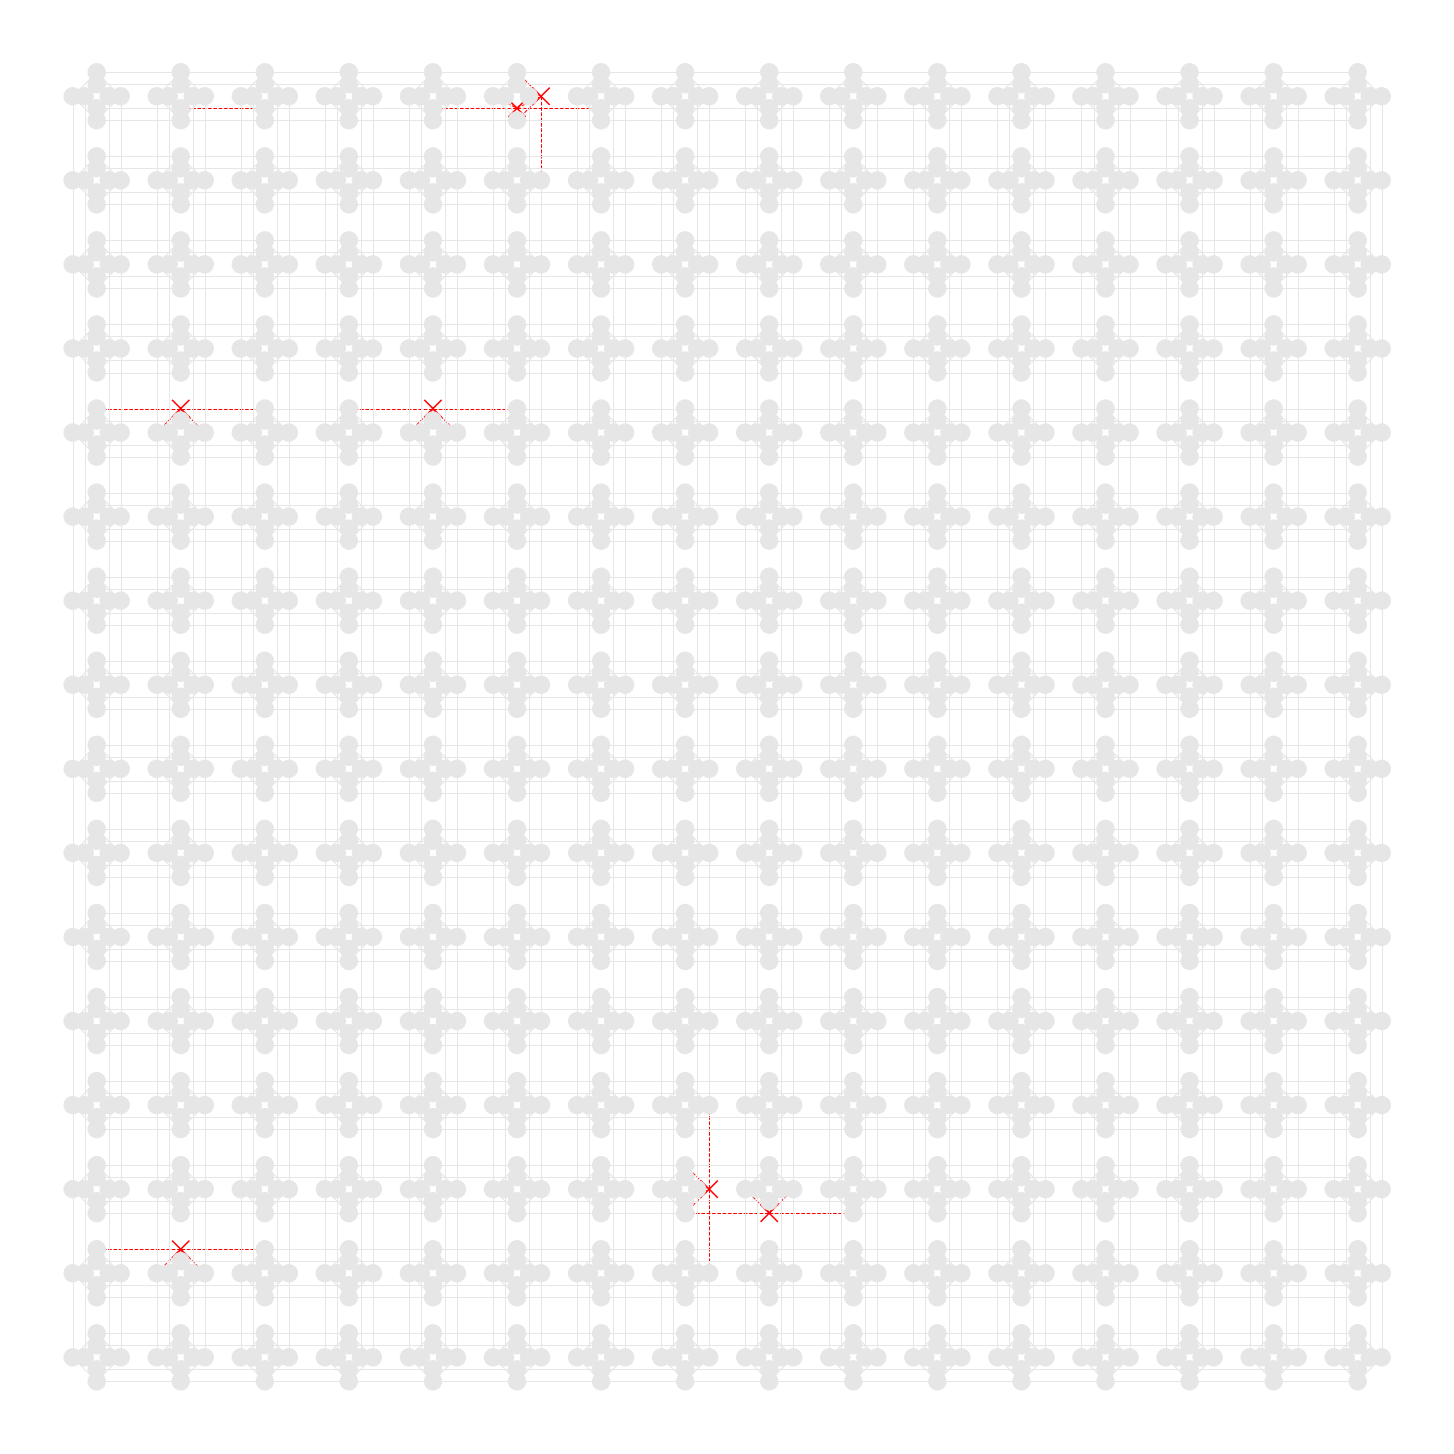

In [23]:
import dwave_networkx as dnx
from matplotlib import pyplot as plt

plt.ion()
plt.figure(figsize=(20, 20))
with open('collection/DW_2000Q_6.pkl', 'rb') as handle:
    h1 = pickle.load(handle)

dnx.draw_chimera_yield(h1)



In [46]:
import pickle

with open('results/non_faulty_coa.pickle', 'rb') as handle:
    temp = pickle.load(handle)

temp


with open('coa.pickle', 'rb') as handle:
    coa = pickle.load(handle)

coa

with open('coa2.pickle', 'rb') as handle:
    coa2 = pickle.load(handle)

coa2
coa2["noisy_bipartite"].update(temp["noisy_bipartite"])

coa["d_regular"].update(coa2["d_regular"])
coa["erdos_reyni"] = coa2["erdos_reyni"]
coa["noisy_bipartite"] = coa2["noisy_bipartite"]
coa


# coa["d_regular"].update(coa2["d_regular"])
# combined = {**coa, **temp}
# combined

# with open('faulty1_qte_9.pickle', 'rb') as handle:
# #     temp2 = pickle.load(handle)
# #
# # temp2
# #
# # combined = {**temp2, **temp}
# combined

#
# temp["noisy_bipartite"].update(temp2["noisy_bipartite"])
# temp
#
# # with open('faulty1_bte_10.pickle', 'rb') as handle:
# #     temp2 = pickle.load(handle)
# #
# # temp2
# #
# # combined = {**temp["noisy_bipartite"], ** temp2["noisy_bipartite"]}
# #
# # with open('faulty1_bte_9.pickle', 'rb') as handle:
# #     temp3 = pickle.load(handle)
# #
# # temp3["noisy_bipartite"] = combined
# # temp3
# #
with open('results/nonfaulty_coa.pickle', 'wb') as handle:
    pickle.dump(coa, handle, protocol=pickle.HIGHEST_PROTOCOL)
# temp3
# combined = {**temp3, **temp2, **temp}
# combined

In [8]:
from ember.template import BipartiteSat, QuadripartiteSat
from ember.hardware.chimera import D_WAVE_2000Q_6, D_WAVE_2000Q_QuAIL, D_WAVE_2000Q
from minorminer import find_embedding

def bte_func(guest, host):
    emb, walltime = BipartiteSat(guest, host).solve(return_walltime=True, timeout=30)
    return emb, walltime

def qte_func(guest, host):
    emb, walltime = QuadripartiteSat(guest, host).solve(return_walltime=True, timeout=30)
    return emb, walltime

def minor_miner_embed_func(guest, host):
    return find_embedding(guest, host, tries=1)

non_faulty = D_WAVE_2000Q()
faulty1 = D_WAVE_2000Q_6()
faulty2 = D_WAVE_2000Q_QuAIL()

# nf_bte = run_benchmark2("nonfaulty", "bte", non_faulty, bte_func)
# with open('results/nonfaulty_bte.pickle', 'wb') as handle:
#     pickle.dump(nf_bte, handle, protocol=pickle.HIGHEST_PROTOCOL)
#
# nf_qte = run_benchmark2("nonfaulty", "qte", non_faulty, qte_func)
# with open('results/nonfaulty_qte.pickle', 'wb') as handle:
#     pickle.dump(nf_qte, handle, protocol=pickle.HIGHEST_PROTOCOL)


f1_mm = run_benchmark3("faulty1", "mm", faulty1, minor_miner_embed_func)
with open('small_results/faulty1_minorminer.pickle', 'wb') as handle:
    pickle.dump(f1_mm, handle, protocol=pickle.HIGHEST_PROTOCOL)

f2_mm = run_benchmark3("faulty2", "mm", faulty2, minor_miner_embed_func)
with open('small_results/faulty2_minorminer.pickle', 'wb') as handle:
    pickle.dump(f2_mm, handle, protocol=pickle.HIGHEST_PROTOCOL)


# f1_bte = run_benchmark2("faulty1", "bte", faulty1, bte_func)
# with open('small_results/faulty1_bte.pickle', 'wb') as handle:
#     pickle.dump(f1_bte, handle, protocol=pickle.HIGHEST_PROTOCOL)
#
# f2_bte = run_benchmark2("faulty2","bte", faulty2, bte_func)
# with open('small_results/faulty2_bte.pickle', 'wb') as handle:
#     pickle.dump(f2_bte, handle, protocol=pickle.HIGHEST_PROTOCOL)
#
# f1_qte = run_benchmark2("faulty1","qte", faulty1, qte_func)
# with open('small_results/faulty1_qte.pickle', 'wb') as handle:
#     pickle.dump(f1_qte, handle, protocol=pickle.HIGHEST_PROTOCOL)
#
# f2_qte = run_benchmark2("faulty2","qte", faulty2, qte_func)
# with open('small_results/faulty2_qte.pickle', 'wb') as handle:
#     pickle.dump(f2_qte, handle, protocol=pickle.HIGHEST_PROTOCOL)



graph type: barabasi_albert
density : low
size:  10
Embedding found
{'max_chain_length': 2, 'median_chain_length': 2.0, 'qubits_used': 16, 'walltime': 0.026307106018066406}
size:  11
Embedding found
{'max_chain_length': 3, 'median_chain_length': 2.0, 'qubits_used': 23, 'walltime': 0.03228306770324707}
size:  12
Embedding found
{'max_chain_length': 3, 'median_chain_length': 2.0, 'qubits_used': 27, 'walltime': 0.041665077209472656}
size:  13
Embedding found
{'max_chain_length': 4, 'median_chain_length': 2.0, 'qubits_used': 31, 'walltime': 0.04360485076904297}
size:  14
Embedding found
{'max_chain_length': 3, 'median_chain_length': 2.0, 'qubits_used': 31, 'walltime': 0.055396080017089844}
size:  15
Embedding found
{'max_chain_length': 4, 'median_chain_length': 3.0, 'qubits_used': 39, 'walltime': 0.07533001899719238}
size:  16
Embedding found
{'max_chain_length': 4, 'median_chain_length': 3.0, 'qubits_used': 49, 'walltime': 0.11347603797912598}
size:  17
Embedding found
{'max_chain_length'

In [3]:
from ember.util import *
import time


def run_benchmark2(host_name, alg_name, host, embed_func):
    results = {}
    count = 0
    for graph_type in ["barabasi_albert", "d_regular", "erdos_reyni", "noisy_bipartite"]:
        print(f"graph type: {graph_type}")
        results[graph_type] = {}
        for density in ["low", "medium", "high"]:
            with open(f'checkpoint2/{host_name}_{alg_name}_{count}.pickle', 'wb') as handle:
                pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
            count += 1
            print(f"density : {density}")
            results[graph_type][density] = {}
            for size in range(10, 65):
                print(f"size:  {size}")
                found = False
                for instance in range(5):
                    guest = all_guests[graph_type][density][size][instance]
                    # start_time = time.time()
                    try:
                        emb, walltime = embed_func(guest, host)
                    except:
                        print("Failed! skipping.....")
                        break
                    # total = time.time() - start_time
                    if check_embedding(emb, guest, host):
                        found = True
                        max_chain, median_length, qubits_used = get_chain_stats(emb)
                        data = {
                            "max_chain_length": max_chain,
                            "median_chain_length": median_length,
                            "qubits_used": qubits_used,
                            "walltime": walltime}
                        print(data)
                        results[graph_type][density][size] = data
                        break
                if not found:
                    break
    return results


In [16]:
import time


def run_benchmark3(host_name, alg_name, host, embed_func):
    results = {}
    count = 0
    for graph_type in ["erdos_reyni", "noisy_bipartite"]:
        print(f"graph type: {graph_type}")
        results[graph_type] = {}
        for density in ["low", "medium", "high"]:
            with open(f'checkpoint/{host_name}_{alg_name}_{count}.pickle', 'wb') as handle:
                pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
            count += 1
            print(f"density : {density}")
            results[graph_type][density] = {}
            for size in range(65, 96):
                print(f"size:  {size}")
                found = False
                for instance in range(5):
                    guest = all_guests[graph_type][density][size][instance]
                    start_time = time.time()
                    emb = embed_func(guest, host)
                    total = time.time() - start_time
                    if check_embedding(emb, guest, host):
                        found = True
                        max_chain, median_length, qubits_used = get_chain_stats(emb)
                        data = {
                            "max_chain_length": max_chain,
                            "median_chain_length": median_length,
                            "qubits_used": qubits_used,
                            "walltime": total}
                        print(data)
                        results[graph_type][density][size] = data
                        break
                if not found:
                    break
    return results



In [11]:
files = ["faulty1_bte", "faulty1_minorminer", "faulty1_qte", "faulty2_bte", "faulty2_minorminer",
         "faulty2_qte"]

for file in files:
    with open(f'small_results/{file}.pickle', 'rb') as handle:
        type = pickle.load(handle)
    for graph_type in ["barabasi_albert", "d_regular", "erdos_reyni", "noisy_bipartite"]:
        for density in ["low", "medium", "high"]:
            for i in range(10, 65):
                if i not in type[graph_type][density]:
                    print(f"{file} {graph_type} {density} {i}")
                    break


faulty1_bte noisy_bipartite low 15
faulty1_minorminer noisy_bipartite low 15
faulty1_qte noisy_bipartite low 15
faulty2_bte noisy_bipartite low 15
faulty2_minorminer noisy_bipartite low 15
faulty2_qte d_regular medium 64
faulty2_qte d_regular high 63
faulty2_qte erdos_reyni medium 64
faulty2_qte noisy_bipartite low 15
faulty2_qte noisy_bipartite high 63


In [ ]:
with open(f'results/non_faulty_pssa.pickle', 'rb') as handle:
    type = pickle.load(handle)

type

with open(f'temp/nonfaulty_pssa_6.pickle', 'rb') as handle:
    typ2 = pickle.load(handle)

combined = {**typ2, **type}

with open(f'results/non_faulty_pssa_2.pickle', 'wb') as handle:
    pickle.dump(combined, handle)



In [24]:
with open(f'results/non_faulty_pssa.pickle', 'rb') as handle:
    type = pickle.load(handle)

type

with open(f'temp/nonfaulty_pssa_6.pickle', 'rb') as handle:
    typ2 = pickle.load(handle)

combined = {**typ2, **type}

with open(f'results/non_faulty_pssa_2.pickle', 'wb') as handle:
    pickle.dump(combined, handle)

